In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
import gdown
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import rioxarray as rio

import micro
import gtsa

## Download sample data

In [3]:
url = 'https://drive.google.com/drive/u/1/folders/1E1FbgeS2YHqnZOsXpbXTIpWhWT1oDR5N'
k13_dem_folder='../data/dems/k13_coreg/'
# gdown.download_folder(url, output=k13_dem_folder, quiet=False, use_cookies=False)

url = 'https://drive.google.com/drive/u/1/folders/1NBJ87RWqVEixA7XuN4uvmtjGJ03JIU56'
m14_dem_folder='../data/dems/m14_coreg/'
# gdown.download_folder(url, output=m14_dem_folder, quiet=False, use_cookies=False)

In [4]:
!tree ../data/dems

../data/dems
├── k13
│   ├── dsyr1
│   │   ├── K13_lidar_20210604_cc.tif
│   │   ├── K13_lidar_20210913_cc.tif
│   │   ├── K13_sfm_20210604_cc.tif
│   │   ├── K13_sfm_20210819_cc.tif
│   │   └── K13_sfm_20210913_cc.tif
│   ├── wsyr1
│   │   ├── K13_lidar_20201109_cc.tif
│   │   ├── K13_lidar_20210513_cc.tif
│   │   ├── K13_sfm_20201109_cc.tif
│   │   ├── K13_sfm_20210208_cc.tif
│   │   ├── K13_sfm_20210406_cc.tif
│   │   └── K13_sfm_20210513_cc.tif
│   └── wsyr2
│       ├── K13_lidar_20211007_cc.tif
│       ├── K13_lidar_20220531_cc.tif
│       ├── K13_sfm_20211007_cc.tif
│       ├── K13_sfm_20220208_cc.tif
│       ├── K13_sfm_20220503_cc.tif
│       └── K13_sfm_20220531_cc.tif
├── k13_coreg
│   └── KID-13
│       ├── dsyr1
│       │   ├── k13_20210604_lidar_coreg.tif
│       │   ├── k13_20210605_sfm_coreg.tif
│       │   ├── k13_20210819_sfm_coreg.tif
│       │   └── k13_20210913_sfm_coreg.tif
│       ├── wsyr1
│       │   ├── k13_20201109_lidar_coreg.tif
│       │   ├── k13_20201110_

In [5]:
k13_wsyr1_dem_files = sorted(Path(k13_dem_folder).glob('KID-13/wsyr1/*.tif'))
k13_wsyr1_dem_files = [i.as_posix() for i in k13_wsyr1_dem_files]

k13_dsyr1_dem_files = sorted(Path(k13_dem_folder).glob('KID-13/dsyr1/*.tif'))
k13_dsyr1_dem_files = [i.as_posix() for i in k13_dsyr1_dem_files]

k13_wsyr2_dem_files = sorted(Path(k13_dem_folder).glob('KID-13/wsyr2/*.tif'))
k13_wsyr2_dem_files = [i.as_posix() for i in k13_wsyr2_dem_files]

m14_wsyr1_dem_files = sorted(Path(m14_dem_folder).glob('MEL-14/wsyr1/*.tif'))
m14_wsyr1_dem_files = [i.as_posix() for i in m14_wsyr1_dem_files]

m14_dsyr1_dem_files = sorted(Path(m14_dem_folder).glob('MEL-14/dsyr1/*.tif'))
m14_dsyr1_dem_files = [i.as_posix() for i in m14_dsyr1_dem_files]

m14_wsyr2_dem_files = sorted(Path(m14_dem_folder).glob('MEL-14/wsyr2/*.tif'))
m14_wsyr2_dem_files = [i.as_posix() for i in m14_wsyr2_dem_files]

In [6]:
k13_wsyr1_dem_files, k13_dsyr1_dem_files, k13_wsyr2_dem_files, \
m14_wsyr1_dem_files, m14_dsyr1_dem_files, m14_wsyr2_dem_files

(['../data/dems/k13_coreg/KID-13/wsyr1/k13_20201109_lidar_coreg.tif',
  '../data/dems/k13_coreg/KID-13/wsyr1/k13_20201110_sfm_coreg.tif',
  '../data/dems/k13_coreg/KID-13/wsyr1/k13_20210208_sfm_coreg.tif',
  '../data/dems/k13_coreg/KID-13/wsyr1/k13_20210406_sfm_coreg.tif',
  '../data/dems/k13_coreg/KID-13/wsyr1/k13_20210513_sfm_coreg.tif'],
 ['../data/dems/k13_coreg/KID-13/dsyr1/k13_20210604_lidar_coreg.tif',
  '../data/dems/k13_coreg/KID-13/dsyr1/k13_20210605_sfm_coreg.tif',
  '../data/dems/k13_coreg/KID-13/dsyr1/k13_20210819_sfm_coreg.tif',
  '../data/dems/k13_coreg/KID-13/dsyr1/k13_20210913_sfm_coreg.tif'],
 ['../data/dems/k13_coreg/KID-13/wsyr2/k13_20211007_lidar_coreg.tif',
  '../data/dems/k13_coreg/KID-13/wsyr2/k13_20211008_sfm_coreg.tif',
  '../data/dems/k13_coreg/KID-13/wsyr2/k13_20220208_sfm_coreg.tif',
  '../data/dems/k13_coreg/KID-13/wsyr2/k13_20220503_sfm_coreg.tif',
  '../data/dems/k13_coreg/KID-13/wsyr2/k13_20220531_sfm_coreg.tif'],
 ['../data/dems/m14_coreg/MEL-14/wsyr1/

## Select analysis ready data
- Assuming SfM and lidar collected on the same data are only used for validation of the SfM data
- Assuming the lidar is always "better" and will thus be used for the quantitative measurements and time series analysis

In [10]:
dsm_files = ['../data/dems/m14_coreg/MEL-14/wsyr2/m14_20220309_lidar_coreg.tif',
  '../data/dems/m14_coreg/MEL-14/wsyr2/m14_20220310_sfm_coreg.tif',
  '../data/dems/m14_coreg/MEL-14/wsyr2/m14_20220316_sfm_coreg.tif',
  '../data/dems/m14_coreg/MEL-14/wsyr2/m14_20220324_sfm_coreg.tif',
  '../data/dems/m14_coreg/MEL-14/wsyr2/m14_20220411_sfm_coreg.tif',
  '../data/dems/m14_coreg/MEL-14/wsyr2/m14_20220428_sfm_coreg.tif',
  '../data/dems/m14_coreg/MEL-14/wsyr2/m14_20220601_sfm_coreg.tif'
            ]

## Parse time stamps

In [11]:
strings = gtsa.io.parse_timestamps(dsm_files, date_string_pattern='_........_')
date_strings = [x[1:-1] for x in strings]

# ensure chronological sorting
date_strings, dsm_files = list(zip(*sorted(zip(date_strings, dsm_files))))
date_times = [pd.to_datetime(x, format='%Y%m%d') for x in date_strings]

In [12]:
list(zip(date_strings, dsm_files))

[('20220309',
  '../data/dems/m14_coreg/MEL-14/wsyr2/m14_20220309_lidar_coreg.tif'),
 ('20220310',
  '../data/dems/m14_coreg/MEL-14/wsyr2/m14_20220310_sfm_coreg.tif'),
 ('20220316',
  '../data/dems/m14_coreg/MEL-14/wsyr2/m14_20220316_sfm_coreg.tif'),
 ('20220324',
  '../data/dems/m14_coreg/MEL-14/wsyr2/m14_20220324_sfm_coreg.tif'),
 ('20220411',
  '../data/dems/m14_coreg/MEL-14/wsyr2/m14_20220411_sfm_coreg.tif'),
 ('20220428',
  '../data/dems/m14_coreg/MEL-14/wsyr2/m14_20220428_sfm_coreg.tif'),
 ('20220601',
  '../data/dems/m14_coreg/MEL-14/wsyr2/m14_20220601_sfm_coreg.tif')]

## Create stack
- resample to reference DEM grid and save as netcdf

In [13]:
k13_mask_path = '../data/vectors/kid_mask/roadClip/KID13_roadClip.shp'
m14_mask_path = '../data/vectors/mel_mask/roadClip/MEL14_roadClip.shp'

# grab shapefile crs to write to rasters
k13_crs = gpd.read_file(k13_mask_path).crs
k13_mask_gdf = gpd.read_file(k13_mask_path)

m14_crs = gpd.read_file(m14_mask_path).crs
m14_mask_gdf = gpd.read_file(m14_mask_path)

In [14]:
gdf = m14_mask_gdf

In [15]:
reference_dem = dsm_files[0]

ds = gtsa.io.xr_stack_geotifs(
    dsm_files,
    date_times,
    reference_dem,
    resampling='cubic',
    save_to_nc=True,
    overwrite=True,
    cleanup=False,
    verbose=True,
)

Resampled 7 of 7 dems to match reference DEM spatial_ref, crs, transform, bounds, and resolution.
Reading files from ../data/dems/m14_coreg/MEL-14/wsyr2


In [16]:
ds.rio.crs

CRS.from_epsg(32610)

In [17]:
ds = ds.rio.clip(gdf["geometry"])

## Ensure `nodata` values are correct

In [26]:
ds_nodata = ds.band1
nd = np.nanmax(ds_nodata.isel(time=5).values)
nd = np.nanmin(ds_nodata.isel(time=6).values)
# ds_nodata = ds_nodata.where(ds_nodata!=nd)

nd

500.12166556893806

In [27]:
print(f"nodata: {ds_nodata.rio.nodata}")
print(f"encoded_nodata: {ds_nodata.rio.encoded_nodata}")

nodata: nan
encoded_nodata: -9999.0


In [28]:
ds_nodata.rio.write_nodata(np.nan, encoded=True,inplace=True)

print(f"nodata: {ds_nodata.rio.nodata}")
print(f"encoded_nodata: {ds_nodata.rio.encoded_nodata}")

nodata: nan
encoded_nodata: nan


## Plot first time stamp

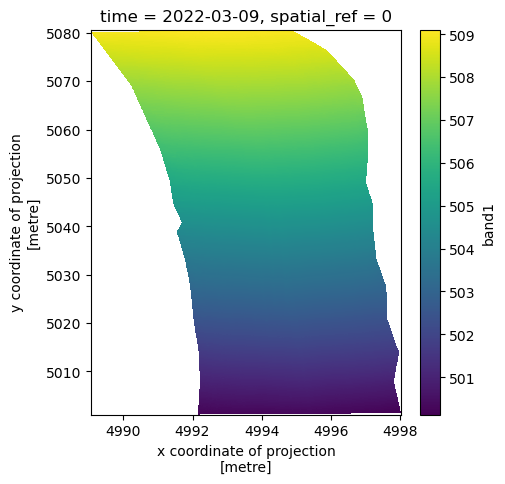

In [29]:
ds_nodata.isel(time=0).plot(aspect='equal',
                              size=5)

## Compute differences for stack

In [30]:
ds_diff = ds_nodata.diff(dim='time')

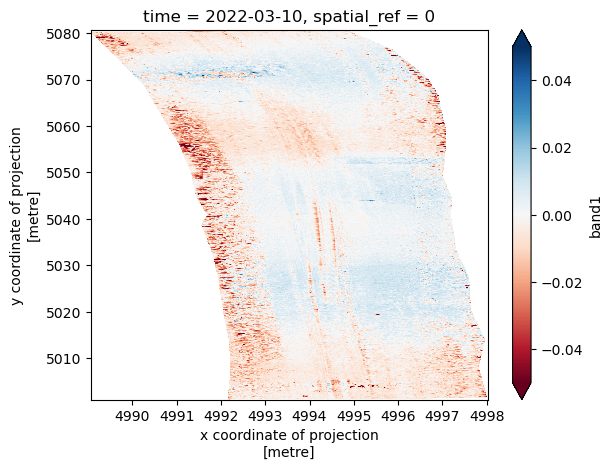

In [31]:
ds_diff.isel(time=0).plot(vmin=-0.05, vmax=0.05, cmap='RdBu')

## Apply HPGF to stacked dataset

In [32]:
sigma = 50
ds_diff_smooth0, size = micro.hpgf.gauss_fltr_astropy_fft(ds_diff.isel(time=0).values, sigma = sigma, origmask=True)
ds_diff_smooth1, size = micro.hpgf.gauss_fltr_astropy_fft(ds_diff.isel(time=1).values, sigma = sigma, origmask=True)
ds_diff_smooth2, size = micro.hpgf.gauss_fltr_astropy_fft(ds_diff.isel(time=2).values, sigma = sigma, origmask=True)
ds_diff_smooth3, size = micro.hpgf.gauss_fltr_astropy_fft(ds_diff.isel(time=3).values, sigma = sigma, origmask=True)
ds_diff_smooth4, size = micro.hpgf.gauss_fltr_astropy_fft(ds_diff.isel(time=4).values, sigma = sigma, origmask=True)
ds_diff_smooth5, size = micro.hpgf.gauss_fltr_astropy_fft(ds_diff.isel(time=5).values, sigma = sigma, origmask=True)

Applying gaussian smoothing filter with size 301 and sigma 50.000 (sum 1.000)
Applying original mask
Applying gaussian smoothing filter with size 301 and sigma 50.000 (sum 1.000)
Applying original mask
Applying gaussian smoothing filter with size 301 and sigma 50.000 (sum 1.000)
Applying original mask
Applying gaussian smoothing filter with size 301 and sigma 50.000 (sum 1.000)
Applying original mask
Applying gaussian smoothing filter with size 301 and sigma 50.000 (sum 1.000)
Applying original mask
Applying gaussian smoothing filter with size 301 and sigma 50.000 (sum 1.000)
Applying original mask


In [33]:
ds_diff = ds_diff - [ds_diff_smooth0, ds_diff_smooth1, ds_diff_smooth2,\
     ds_diff_smooth3, ds_diff_smooth4, ds_diff_smooth5]

## Plot first difference map

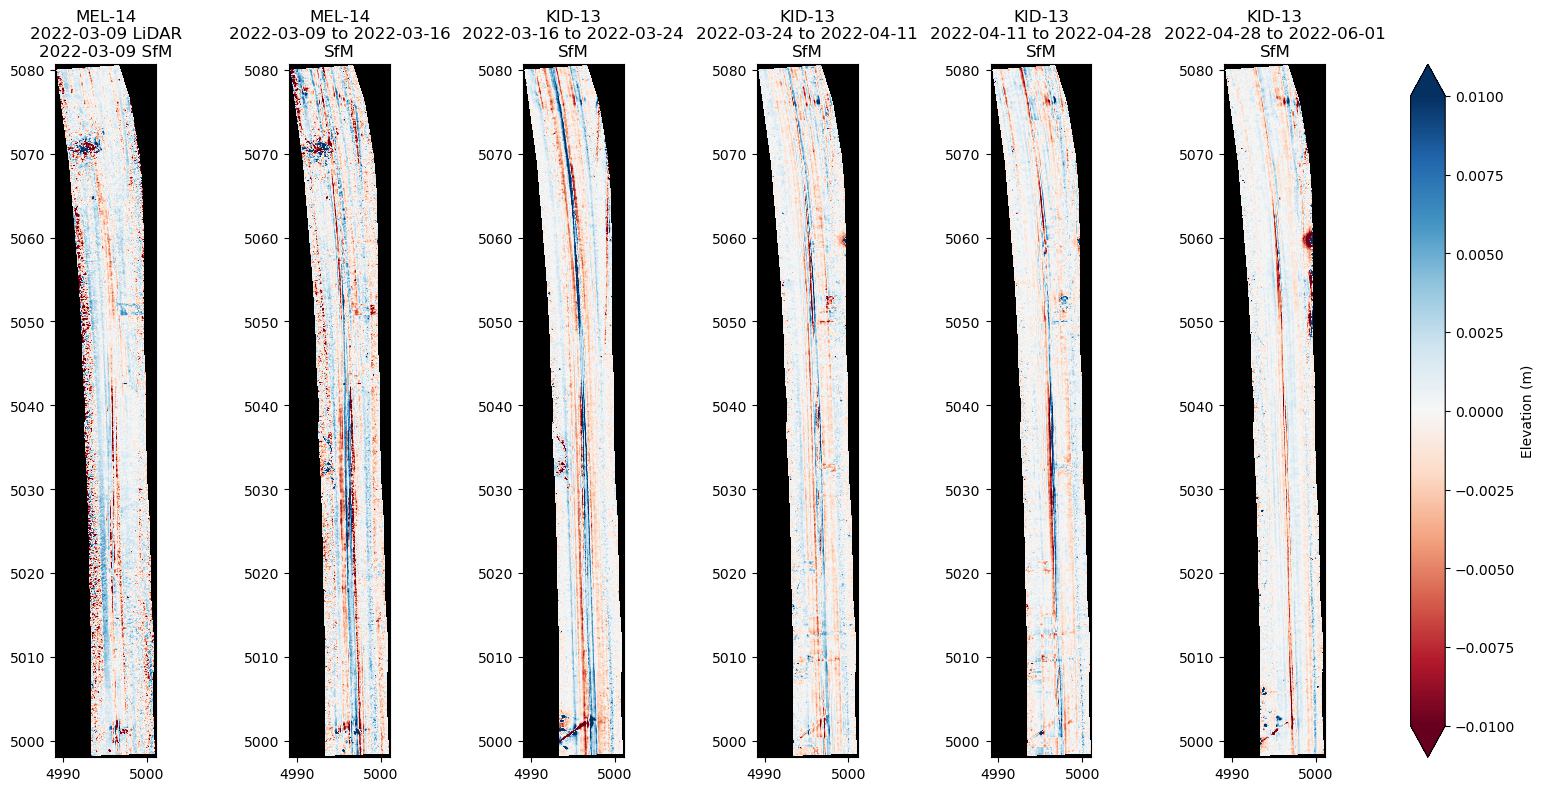

In [34]:
fig, ax = plt.subplots(1, 6, figsize=(22,9))

ds_extent= ds_diff.rio.bounds()
m = ax[0].imshow(ds_diff.isel(time=0), cmap = 'RdBu', vmin=-0.01, vmax=0.01)
fig.colorbar(m, label='Elevation (m)', extend='both', ax=ax)

ax[0].imshow(ds_diff.isel(time=0), cmap='RdBu', vmin=-0.01, vmax=0.01, extent = ds_extent)
ax[0].set_title('MEL-14\n2022-03-09 LiDAR\n2022-03-09 SfM')
ax[0].set_facecolor('k')

ax[1].imshow(ds_diff.isel(time=1), cmap='RdBu', vmin=-0.01, vmax=0.01, extent = ds_extent)
ax[1].set_title('MEL-14\n2022-03-09 to 2022-03-16\nSfM')
ax[1].set_facecolor('k')

ax[2].imshow(ds_diff.isel(time=2), cmap='RdBu', vmin=-0.01, vmax=0.01, extent = ds_extent)
ax[2].set_title('KID-13\n2022-03-16 to 2022-03-24\nSfM')
ax[2].set_facecolor('k')

ax[3].imshow(ds_diff.isel(time=3), cmap='RdBu', vmin=-0.01, vmax=0.01, extent = ds_extent)
ax[3].set_title('KID-13\n2022-03-24 to 2022-04-11\nSfM')
ax[3].set_facecolor('k')

ax[4].imshow(ds_diff.isel(time=4), cmap='RdBu', vmin=-0.01, vmax=0.01, extent = ds_extent)
ax[4].set_title('KID-13\n2022-04-11 to 2022-04-28\nSfM')
ax[4].set_facecolor('k')

ax[5].imshow(ds_diff.isel(time=5), cmap='RdBu', vmin=-0.01, vmax=0.01, extent = ds_extent)
ax[5].set_title('KID-13\n2022-04-28 to 2022-06-01\nSfM')
ax[5].set_facecolor('k')

## Read shapefile

In [ ]:
# shapefiles = [x.as_posix() for x in sorted(Path(vector_folder).glob('*.shp'))]
# gdf = gpd.read_file(shapefiles[0])

## Plot shapefile

In [ ]:
# fig,ax = plt.subplots(figsize=(10,10))

# ds_diff.isel(time=0).plot(ax=ax,
#                           cmap='RdBu',
#                           vmin=-0.05,
#                           vmax=0.05,
#                           )

# xlim = ax.get_xlim()
# ylim = ax.get_ylim()

# gdf.plot(ax=ax, facecolor='none', edgecolor='black')

## Clip stack for each geometry

In [ ]:
# geometry_0 = gpd.GeoDataFrame(gpd.GeoSeries(gdf.iloc[0]['geometry']), columns=['geometry'])
# geometry_1 = gpd.GeoDataFrame(gpd.GeoSeries(gdf.iloc[1]['geometry']), columns=['geometry'])

In [ ]:
# ds_diff_clip_geom_0 = ds_diff.rio.clip(geometry_0['geometry'])
# ds_diff_clip_geom_1 = ds_diff.rio.clip(geometry_1['geometry'])

## Plot first time step in clipped stack

In [ ]:
# fig,ax = plt.subplots(figsize=(10,10))

# ds_diff_clip_geom_0.isel(time=0).plot(ax=ax,
#                                       cmap='RdBu',
#                                       vmin=-0.05,
#                                       vmax=0.05,
#                                       add_colorbar=False,
#                                      )

# geometry_0.plot(ax=ax, facecolor='none', edgecolor='green')

# ds_diff_clip_geom_1.isel(time=0).plot(ax=ax,
#                                       cmap='RdBu',
#                                       vmin=-0.05,
#                                       vmax=0.05,
#                                       cbar_kwargs={'extend': 'both'},
#                                      )

# geometry_1.plot(ax=ax, facecolor='none', edgecolor='purple')

# ax.set_xlim(xlim)
# ax.set_ylim(ylim);

## Plot time series for mean difference value

In [ ]:
# fig,ax = plt.subplots(figsize=(10,5))
# ds_diff_clip_geom_0.mean(dim=['x','y']).plot.scatter(ax=ax,color='green')
# ds_diff_clip_geom_1.mean(dim=['x','y']).plot.scatter(ax=ax,color='purple')